In [2]:
import os
import yaml
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, LineString
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
from adcircpy import AdcircMesh

In [3]:
# Paths to the input/output files
f14file = "/home/sbunya/GitHub/adcircutils/adcircutils/vewchannel/examples/example1/fort_without_vews.14"
vewlocation_geofile = "/home/sbunya/GitHub/adcircutils/adcircutils/vewchannel/examples/example1/example1_vew_locations.shp"
vewfile = "/home/sbunya/GitHub/adcircutils/adcircutils/vewchannel/examples/example1/vewstings.yaml"

# Parameters
dist_max = 10.0  # Maximum distance for nearest neighbor search in meters

In [4]:
# Read the shapefile
vewlocation_gdf = gpd.read_file(vewlocation_geofile)
print(vewlocation_gdf)

   ID                                           geometry
0   1  LINESTRING Z (-701.8 498.5 1, -701.8 1501.5 1,...
1   2  LINESTRING Z (-898.515 602.124 1, -1100.5 596....
2   3  LINESTRING Z (-901.7 1098.5 1, -1096.2 1100.1 ...
3   5  LINESTRING Z (103.8 795.7 1, 100.7 696.9 1, -1...
4   6  LINESTRING Z (1202.4 502 1, 1198.9 698.7 1, 13...
5   8  LINESTRING Z (-304.8 495 1, 202.547 503.842 1,...


/home/sbunya/miniforge3/envs/vew1d_3.11/lib/python3.11/site-packages/pyogrio/raw.py:198: UserWarning: Measured (M) geometry types are not supported. Original type 'Measured 3D LineString' is converted to 'LineString Z'
  return ogr_read(


In [5]:
# Load the mesh file
mesh = AdcircMesh.open(f14file)

/home/sbunya/GitHub/adcircpy/adcircpy/mesh/parsers/grd.py:277: UserWarning: File does not contain CRS information and no CRS was given: "/home/sbunya/GitHub/adcircutils/adcircutils/vewchannel/examples/example1/fort_without_vews.14"
  warnings.warn(


In [28]:
# Create nodestrings along the lines in the geospatial file
x = mesh.nodes.x
y = mesh.nodes.y

# Create a KDTree for fast nearest neighbor search
tree = cKDTree(np.c_[x.values, y.values])

neighs = mesh.node_neighbors.copy()
# neighs = [neighs.iloc[i] for i in range(len(neighs))]

nodestrings = []

for iline, line in enumerate(vewlocation_gdf.geometry):
    slx, sly = line.coords[0][0], line.coords[0][1]
    elx, ely = line.coords[-1][0], line.coords[-1][1]
    
    # Query the KDTree for the nearest neighbor
    distance, nearest_node_index = tree.query([slx, sly])

    # Get the coordinates of the nearest node
    nearest_node_x = x.iloc[nearest_node_index]
    nearest_node_y = y.iloc[nearest_node_index]

    ni = nearest_node_index + 1
    xi = nearest_node_x
    yi = nearest_node_y
    distance_to_endpoint = 1e10
    
    nodestring = [ni]
    
    ipos = 0
    while ipos < len(line.coords) - 1:
        # Get the points in the line segment
        point0 = line.coords[ipos]
        point1 = line.coords[ipos + 1]
        xl0, yl0 = point0[0], point0[1]
        xl1, yl1 = point1[0], point1[1]

        line_segment = LineString([(xl0, yl0), (xl1, yl1)])
        
        neigh = neighs[ni]
        neigh = [n for n in neigh if n not in nodestring]

        xnei = [x.loc[n] for n in neigh]
        ynei = [y.loc[n] for n in neigh]
        
        # Compute the distances from the line to the points defined by xnei and ynei
        distances = [line_segment.distance(Point(xn, yn)) for xn, yn in zip(xnei, ynei)]
        min_distance = np.min(distances)
        
        if min_distance > dist_max:
            ipos += 1
            continue
        
        min_distance_index = np.argmin(distances)
        ni = neigh[min_distance_index]
        xi = x[ni]
        yi = y[ni]
        
        nodestring.append(int(ni))
        
        distance_to_endpoint = np.sqrt((elx - xi)**2 + (ely - yi)**2)
        
        if distance_to_endpoint < dist_max:
            break

    xi, yi = x.loc[nodestring[0]], y.loc[nodestring[0]]
    distance_to_endpoint = np.sqrt((elx - xi)**2 + (ely - yi)**2)
    if distance_to_endpoint < dist_max:
        nodestring.append(int(nodestring[0]))
        
    nodestrings.append(nodestring)

[np.float64(-700.0), np.float64(-700.0), np.float64(-700.0), np.float64(-700.0), np.float64(-700.0), np.float64(-700.0), np.float64(-700.0), np.float64(-700.0), np.float64(-700.0), np.float64(-700.0), np.float64(-700.0), np.float64(-800.0), np.float64(-900.0), np.float64(-1000.0), np.float64(-1100.0), np.float64(-1200.0), np.float64(-1300.0), np.float64(-1300.0), np.float64(-1300.0), np.float64(-1300.0), np.float64(-1300.0), np.float64(-1300.0), np.float64(-1300.0), np.float64(-1300.0), np.float64(-1300.0), np.float64(-1300.0), np.float64(-1300.0)]
[np.float64(-900.0), np.float64(-1000.0), np.float64(-1100.0), np.float64(-1100.0), np.float64(-1100.0), np.float64(-1100.0), np.float64(-1000.0), np.float64(-900.0), np.float64(-900.0), np.float64(-900.0), np.float64(-900.0)]
[np.float64(-900.0), np.float64(-1000.0), np.float64(-1100.0), np.float64(-1100.0), np.float64(-1100.0), np.float64(-1000.0), np.float64(-900.0), np.float64(-900.0), np.float64(-900.0)]
[np.float64(100.0), np.float64(1

Text(0, 0.5, 'Y Coordinate')

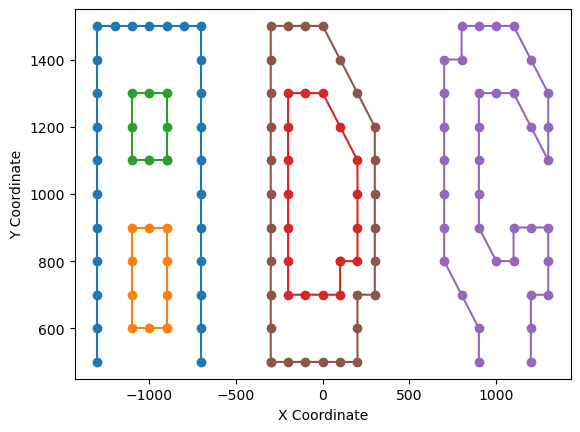

In [29]:
# Visualize the nodestrings
fig, ax = plt.subplots()
for nodestring in nodestrings:
    x_nodes = [x[n] for n in nodestring]
    y_nodes = [y[n] for n in nodestring]
    ax.plot(x_nodes, y_nodes, marker='o')
    print(x_nodes)
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')

In [32]:
# Assign values to each node in the nodestrings
nodestrings_with_values = []
for nodestring in nodestrings:
    nodestring_with_value = \
        [{'node_id': node, 
          'x': float(mesh.nodes.x.loc[node]), 'y': float(mesh.nodes.y.loc[node]),
          'bank_elevation': 2.0 if mesh.nodes.y.loc[node] > 600.0 else 1.0 if mesh.nodes.y.loc[node] > 500.0 else -4.0,
          'bank_mannings_n': 0.03,
          } for node in nodestring]
    nodestrings_with_values.append(nodestring_with_value)

# Prepare the data for YAML output
data = {'vewstrings': nodestrings_with_values}

# Print the YAML output
print(yaml.dump(data, sort_keys=False))

# Write the YAML output to a file
with open(vewfile, 'w') as f:
    yaml.dump(data, f, sort_keys=False)

vewstrings:
- - node_id: 164
    x: -700.0
    y: 500.0
    bank_elevation: -4.0
    bank_mannings_n: 0.03
  - node_id: 195
    x: -700.0
    y: 600.0
    bank_elevation: 1.0
    bank_mannings_n: 0.03
  - node_id: 226
    x: -700.0
    y: 700.0
    bank_elevation: 2.0
    bank_mannings_n: 0.03
  - node_id: 257
    x: -700.0
    y: 800.0
    bank_elevation: 2.0
    bank_mannings_n: 0.03
  - node_id: 288
    x: -700.0
    y: 900.0
    bank_elevation: 2.0
    bank_mannings_n: 0.03
  - node_id: 319
    x: -700.0
    y: 1000.0
    bank_elevation: 2.0
    bank_mannings_n: 0.03
  - node_id: 350
    x: -700.0
    y: 1100.0
    bank_elevation: 2.0
    bank_mannings_n: 0.03
  - node_id: 381
    x: -700.0
    y: 1200.0
    bank_elevation: 2.0
    bank_mannings_n: 0.03
  - node_id: 412
    x: -700.0
    y: 1300.0
    bank_elevation: 2.0
    bank_mannings_n: 0.03
  - node_id: 443
    x: -700.0
    y: 1400.0
    bank_elevation: 2.0
    bank_mannings_n: 0.03
  - node_id: 474
    x: -700.0
    y: 1500